# Phase 2: Modeling & Rapid GPU-Accelerated Tuning

We will:
1. Load data & create targets  
2. Split in time order (75% train / 25% test)  
3. Impute missing values  
4. Define models & reduced hyperparameter spaces  
5. Fast tuning: 3-fold CV, subsample RF, n_iter=3, early stopping on XGB  
6. LightGBM on GPU for ultra-fast trees  
7. Build stacking ensemble  
8. Evaluate classifiers (with threshold tuning)  
9. Tune & evaluate regressors  
10. Full-data CV & auto-select best  
11. Retrain chosen model on all data & save  

In [ ]:
# Parameters cell for Papermill
DATA_PROCESSED = "data/processed"

## 1. Imports & Configuration
- 3-fold CV  
- GPU for XGBoost & LightGBM  
- CPU models single-threaded  

In [1]:
import os, warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import (
    RandomizedSearchCV, GridSearchCV, TimeSeriesSplit,
    ParameterGrid, cross_val_score
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier,
    RandomForestRegressor
)
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    mean_squared_error, precision_recall_curve
)
import xgboost as xgb
from lightgbm import LGBMClassifier, LGBMRegressor
import joblib

warnings.filterwarnings("ignore", message=".*not used.*")
%matplotlib inline
%load_ext autotime
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8,5)


time: 1.11 ms (started: 2025-05-02 17:39:30 +05:30)


## 2. Load Data & Create Targets

In [ ]:
%%time

# Debug: show what's in data/processed
print("DEBUG: data/processed contains:", os.listdir(DATA_PROCESSED))

df = pd.read_csv(os.path.join(DATA_PROCESSED, "historical_proc.csv"), parse_dates=["date"])
df.sort_values("date", inplace=True)
df["close_next"] = df["close"].shift(-1)
df["high_next"]  = df["high"].shift(-1)
df["low_next"]   = df["low"].shift(-1)
df["target_up"]   = (df["close_next"] > df["close"]).astype(int)
df["target_high"] = df["high_next"]
df["target_low"]  = df["low_next"]
df.dropna(subset=["target_up","target_high","target_low"], inplace=True)


CPU times: total: 1min 19s
Wall time: 1min 25s
time: 1min 25s (started: 2025-05-02 17:39:30 +05:30)


## 3. Feature Matrix & Time-Ordered Split

In [3]:
%%time
feature_cols = [c for c in df.columns 
                if c.endswith(("_std","_mm")) 
                or c in ["year","month","day","weekday"]]
X = df[feature_cols]
y_up, y_high, y_low = df["target_up"], df["target_high"], df["target_low"]
split = int(len(df)*0.75)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_up_train, y_up_test = y_up.iloc[:split], y_up.iloc[split:]
y_high_train, y_high_test = y_high.iloc[:split], y_high.iloc[split:]
y_low_train, y_low_test = y_low.iloc[:split], y_low.iloc[split:]
print(f"Train/Test rows: {X_train.shape[0]}/{X_test.shape[0]}")


Train/Test rows: 3299567/1099856
CPU times: total: 328 ms
Wall time: 333 ms
time: 341 ms (started: 2025-05-02 17:40:56 +05:30)


## 4. Impute Missing Feature Values

In [4]:
%%time
imputer = SimpleImputer(strategy="mean")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_cols)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=feature_cols)


CPU times: total: 3.23 s
Wall time: 3.35 s
time: 3.36 s (started: 2025-05-02 17:40:57 +05:30)


## 5. Define Models & Reduced Hyperparams
- LogisticRegression  
- RandomForest (subsample RF tuning)  
- XGBoost (GPU + early stopping)  
- LightGBM (GPU)  
- 3-fold TimeSeriesSplit  

In [5]:
%%time
tscv = TimeSeriesSplit(n_splits=3)

# CPU models
lr_clf = LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42)
rf_clf = RandomForestClassifier(class_weight="balanced", n_jobs=1, random_state=42)

# XGBoost on GPU (new API)
xgb_clf = xgb.XGBClassifier(
    tree_method="hist",       # CPU or GPU histogram algorithm
    device="cuda",            # run on your NVIDIA RTX 4050
    eval_metric="logloss",
    random_state=42
)

# LightGBM on GPU (unchanged)
lgb_clf = LGBMClassifier(
    device="gpu", gpu_platform_id=0, gpu_device_id=0,
    n_estimators=100, max_depth=7, learning_rate=0.05,
    random_state=42
)

param_lr  = {"C": [0.1, 1]}
param_rf  = {"n_estimators": [50, 100], "max_depth": [5, 10]}
param_xgb = {"n_estimators": [100, 200], "max_depth": [3, 5], "learning_rate": [0.05, 0.1]}
param_lgb = {"n_estimators": [100, 200], "max_depth": [5, 7], "learning_rate": [0.05, 0.1]}

CPU times: total: 0 ns
Wall time: 486 μs
time: 16.7 ms (started: 2025-05-02 17:41:00 +05:30)


## 6. Fast Hyperparameter Tuning

- RF subsampled to 30% of training  
- `n_iter=3` for randomized searches  
- **No early-stopping** in CV loops  


In [6]:
%%time

from datetime import datetime

def tune_fast(model, params, X, y, name, max_iter=3, frac=0.3):
    print(f"\n▶ Starting tuning for {name} at {datetime.now().strftime('%H:%M:%S')}")
    start = datetime.now()
    # 1) Subsample RF
    if isinstance(model, RandomForestClassifier):
        n = int(len(X) * frac)
        idx = np.random.RandomState(42).choice(len(X), size=n, replace=False)
        Xt, yt = X.iloc[idx], y.iloc[idx]
    else:
        Xt, yt = X, y

    # 2) Choose Grid vs Random, with verbose=2
    total = len(list(ParameterGrid(params)))
    if total <= max_iter:
        search = GridSearchCV(
            model, params,
            cv=tscv,
            scoring="accuracy",
            n_jobs=1,
            verbose=2
        )
    else:
        search = RandomizedSearchCV(
            model, params,
            n_iter=max_iter,
            cv=tscv,
            scoring="accuracy",
            n_jobs=1,
            random_state=42,
            verbose=2
        )

    # 3) Fit (no early-stopping kwargs)
    search.fit(Xt, yt)

    # 4) Report
    elapsed = (datetime.now() - start).total_seconds()
    print(f"✔ Finished {name} in {elapsed:.1f}s")
    print(f"{name} best params: {search.best_params_}")
    print(f"{name} CV acc: {search.best_score_:.4f}\n")
    return search.best_estimator_

best_lr  = tune_fast(lr_clf,  param_lr,  X_train_imp, y_up_train, "Logistic")
best_rf  = tune_fast(rf_clf,  param_rf,  X_train_imp, y_up_train, "RandomForest")
best_xgb = tune_fast(xgb_clf, param_xgb, X_train_imp, y_up_train, "XGBoost (GPU)")
best_lgb = tune_fast(lgb_clf, param_lgb, X_train_imp, y_up_train, "LightGBM (GPU)")


▶ Starting tuning for Logistic at 17:41:00
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ..............................................C=0.1; total time=   9.8s
[CV] END ..............................................C=0.1; total time=   6.2s
[CV] END ..............................................C=0.1; total time=   8.2s
[CV] END ................................................C=1; total time=   8.9s
[CV] END ................................................C=1; total time=   6.1s
[CV] END ................................................C=1; total time=   8.2s
✔ Finished Logistic in 74.0s
Logistic best params: {'C': 0.1}
Logistic CV acc: 0.5019


▶ Starting tuning for RandomForest at 17:42:14
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ......................max_depth=5, n_estimators=100; total time= 1.5min
[CV] END ......................max_depth=5, n_estimators=100; total time= 3.0min
[CV] END ......................max_depth=5, n_estimator

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:729: UserWarning: [18:26:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   5.9s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   4.9s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   7.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   3.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   5.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.3s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   2.8s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   4.6s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   6.0s
✔ Finished XGBoost (GPU) in 58.0s
XGBoost (GPU) best params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1}
XGBoost (GPU) CV acc: 0.6839


▶ Starting tuning for LightGBM (GPU) at 18:27:28
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LightGBM] 

## 7. Stacking Ensemble

Combine the three tuned classifiers.

In [8]:
%%time
from datetime import datetime
from sklearn.ensemble import StackingClassifier

print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting prefitted stacking...")

stack_clf = StackingClassifier(
    estimators=[
        ("lr",  best_lr),
        ("rf",  best_rf),
        ("xgb", best_xgb),
        ("lgb", best_lgb)
    ],
    final_estimator=LogisticRegression(max_iter=2000, verbose=1),  # verbose for meta-learner
    cv='prefit',
    n_jobs=1,
    passthrough=False
)

stack_clf.fit(X_train_imp, y_up_train)

print(f"[{datetime.now().strftime('%H:%M:%S')}] Prefitted stacking complete.")


[19:56:21] Starting prefitted stacking...
[19:58:18] Prefitted stacking complete.
CPU times: total: 3min 12s
Wall time: 1min 56s
time: 1min 56s (started: 2025-05-02 19:56:21 +05:30)


## 8. Evaluate Classifiers


Logistic — Acc: 0.4980
              precision    recall  f1-score   support

           0       0.50      0.19      0.27    554087
           1       0.50      0.82      0.62    545769

    accuracy                           0.50   1099856
   macro avg       0.50      0.50      0.44   1099856
weighted avg       0.50      0.50      0.44   1099856



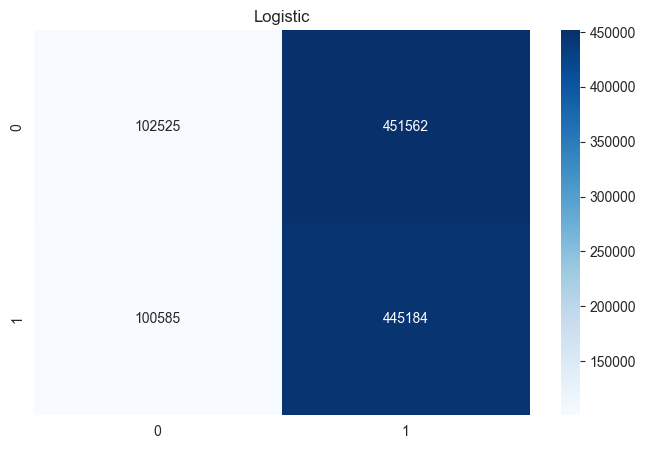


RF — Acc: 0.7189
              precision    recall  f1-score   support

           0       0.68      0.83      0.75    554087
           1       0.78      0.60      0.68    545769

    accuracy                           0.72   1099856
   macro avg       0.73      0.72      0.71   1099856
weighted avg       0.73      0.72      0.71   1099856



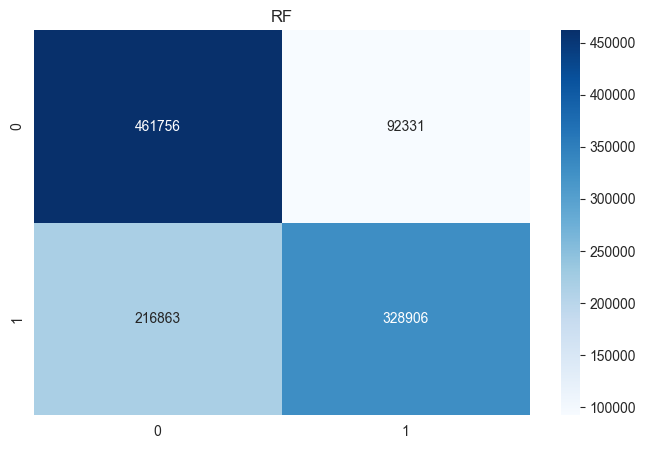


XGBoost — Acc: 0.7202
              precision    recall  f1-score   support

           0       0.68      0.84      0.75    554087
           1       0.78      0.60      0.68    545769

    accuracy                           0.72   1099856
   macro avg       0.73      0.72      0.72   1099856
weighted avg       0.73      0.72      0.72   1099856



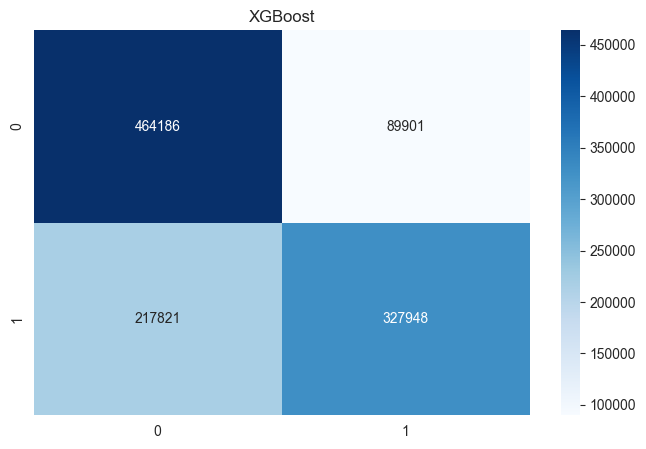


LGB — Acc: 0.7153
              precision    recall  f1-score   support

           0       0.68      0.83      0.75    554087
           1       0.78      0.59      0.67    545769

    accuracy                           0.72   1099856
   macro avg       0.73      0.71      0.71   1099856
weighted avg       0.73      0.72      0.71   1099856



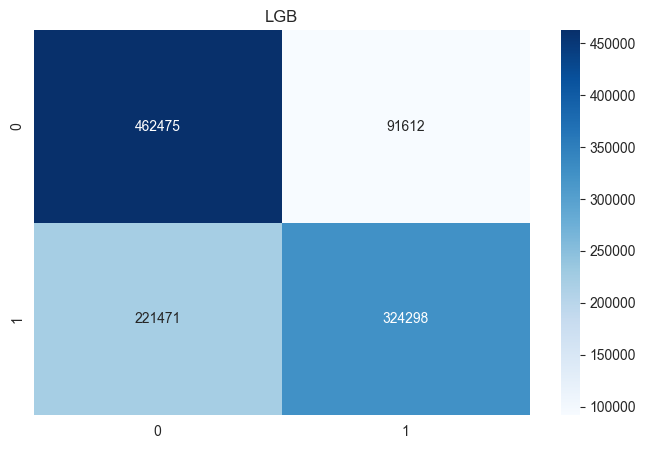


Stack — Acc: 0.7146
              precision    recall  f1-score   support

           0       0.67      0.84      0.75    554087
           1       0.78      0.59      0.67    545769

    accuracy                           0.71   1099856
   macro avg       0.73      0.71      0.71   1099856
weighted avg       0.73      0.71      0.71   1099856



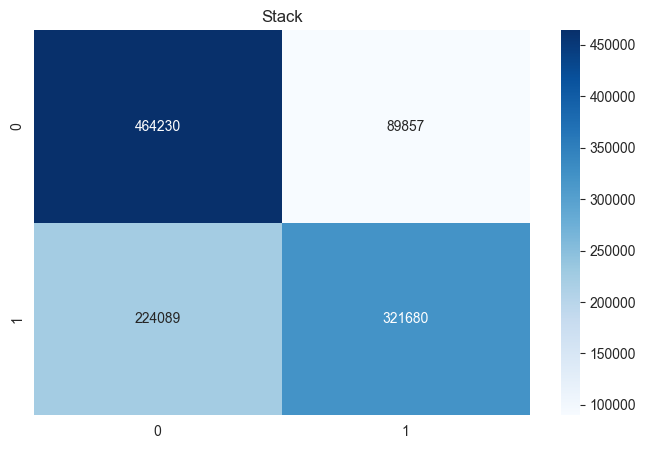

CPU times: total: 2min 10s
Wall time: 1min 21s
time: 1min 21s (started: 2025-05-02 19:58:18 +05:30)


In [9]:
%%time
for n,m in [("Logistic",best_lr),("RF",best_rf),
            ("XGBoost",best_xgb),("LGB",best_lgb),
            ("Stack",stack_clf)]:
    yp = m.predict(X_test_imp)
    print(f"\n{n} — Acc: {accuracy_score(y_up_test, yp):.4f}")
    print(classification_report(y_up_test, yp))
    sns.heatmap(confusion_matrix(y_up_test, yp), 
                annot=True, fmt="d", cmap="Blues")
    plt.title(n); plt.show()


## 9. Threshold Tuning for Stacking

Optimize decision threshold on stacking’s probabilities to maximize F1.

In [10]:
%%time
probs = stack_clf.predict_proba(X_test_imp)[:,1]
prec, rec, thr = precision_recall_curve(y_up_test, probs)
f1 = 2*prec*rec/(prec+rec)
opt = thr[np.nanargmax(f1)]
print(f"Opt thresh: {opt:.3f}")
y_opt = (probs>=opt).astype(int)
print("Stack@opt Acc:", accuracy_score(y_up_test, y_opt))
print(classification_report(y_up_test, y_opt))

Opt thresh: 0.217
Stack@opt Acc: 0.7066597809167745
              precision    recall  f1-score   support

           0       0.81      0.55      0.65    554087
           1       0.65      0.87      0.75    545769

    accuracy                           0.71   1099856
   macro avg       0.73      0.71      0.70   1099856
weighted avg       0.73      0.71      0.70   1099856

CPU times: total: 1min 3s
Wall time: 39 s
time: 39 s (started: 2025-05-02 19:59:39 +05:30)


## 10. Regression Tuning for Next-Day High/Low

Tune regressors on the same TimeSeriesSplit & hyperparameter approach.

In [ ]:
%%time
import pandas as pd
import os
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb

# 1) Drop NaNs in targets
mask_h = ~y_high_train.isna()
mask_l = ~y_low_train.isna()
Xh = X_train_imp.loc[mask_h]; yh = y_high_train.loc[mask_h]
Xl = X_train_imp.loc[mask_l]; yl = y_low_train.loc[mask_l]

# 2) Remove zero-variance features
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.0)
vt.fit(X_train_imp)
keep_cols = [c for c, keep in zip(feature_cols, vt.get_support()) if keep]
Xh = Xh[keep_cols]; Xl = Xl[keep_cols]

# 3) Define regressors with updated GPU settings
rf_regr = RandomForestRegressor(n_jobs=1, random_state=42)
lgb_regr = LGBMRegressor(
    device="gpu", gpu_platform_id=0, gpu_device_id=0,
    n_estimators=100, max_depth=7, min_child_samples=20,
    learning_rate=0.05, random_state=42
)
xgb_regr = xgb.XGBRegressor(
    tree_method="hist", device="cuda",
    objective="reg:squarederror", eval_metric="rmse",
    random_state=42
)

# 4) Set up CV and parameter grids
tscv = TimeSeriesSplit(n_splits=3)
models = {
    "RF High":  (rf_regr, {"n_estimators":[50,100],"max_depth":[5,10]}, Xh, yh),
    "LGB High": (lgb_regr, {"n_estimators":[100,200],"max_depth":[5,7],"learning_rate":[0.05,0.1]}, Xh, yh),
    "XGB High": (xgb_regr, {"n_estimators":[100,200],"max_depth":[3,5],"learning_rate":[0.05,0.1]}, Xh, yh),
    "RF Low":   (rf_regr, {"n_estimators":[50,100],"max_depth":[5,10]}, Xl, yl),
    "LGB Low":  (lgb_regr, {"n_estimators":[100,200],"max_depth":[5,7],"learning_rate":[0.05,0.1]}, Xl, yl),
    "XGB Low":  (xgb_regr, {"n_estimators":[100,200],"max_depth":[3,5],"learning_rate":[0.05,0.1]}, Xl, yl),
}

best_regr = {}
for name, (model, params, Xtr, ytr) in models.items():
    print(f"\n▶ Tuning {name}")
    search = RandomizedSearchCV(
        model, params, n_iter=3, cv=tscv,
        scoring="neg_root_mean_squared_error",
        n_jobs=1, random_state=42, verbose=2
    )
    search.fit(Xtr, ytr)
    best_regr[name] = search.best_estimator_
    print(f"{name} best RMSE: {-search.best_score_:.3f}")



▶ Starting tuning for LGB Regr High at 20:00:18
Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 824894, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (9.44 MB) transferred to GPU in 0.054871 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 461.018583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  33.1s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 1649785, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (18.88 MB) transferred to GPU in 0.080109 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 414.228877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  28.0s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 2474676, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (28.32 MB) transferred to GPU in 0.096290 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 290.224705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=200; total time=  34.4s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 824894, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (9.44 MB) transferred to GPU in 0.039699 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 461.018583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  15.7s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 1649785, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (18.88 MB) transferred to GPU in 0.060444 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 414.228877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  26.9s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 2474676, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (28.32 MB) transferred to GPU in 0.095815 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 290.224705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=  34.9s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 824894, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (9.44 MB) transferred to GPU in 0.035357 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 461.018583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  10.0s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2100
[LightGBM] [Info] Number of data points in the train set: 1649785, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (18.88 MB) transferred to GPU in 0.074100 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 414.228877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  14.7s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 2474676, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (28.32 MB) transferred to GPU in 0.102368 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 290.224705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=100; total time=  16.9s
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2101
[LightGBM] [Info] Number of data points in the train set: 3299567, number of used features: 12
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 12 dense feature groups (37.76 MB) transferred to GPU in 0.181700 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 309244.699175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   4.2s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:04:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   5.1s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:04:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   7.2s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:04:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device

[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   3.4s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:04:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device

[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   5.0s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:04:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device

[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   7.0s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:04:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   2.8s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:05:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:05:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:05:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   4.5s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:05:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:05:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\core.py:2676: UserWarning: [20:05:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device

[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=100; total time=   6.1s


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:05:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:05:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✔ Finished XGB Regr High in 54.5s
XGB Regr High best params: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05}
XGB Regr High CV acc: nan


▶ Starting tuning for RF Regr High at 20:05:17
Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ......................max_depth=5, n_estimators=100; total time=16.1min


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ......................max_depth=5, n_estimators=100; total time=35.0min


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END ......................max_depth=5, n_estimators=100; total time=41.3min


c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Divit\OneDrive\Desktop\Python\crypto-ml-project\.venv\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **s

[CV] END .....................max_depth=10, n_estimators=100; total time=20.3min


KeyboardInterrupt: 

time: 2h 29min 29s (started: 2025-05-02 20:00:18 +05:30)


## 11. Evaluate Regression Models

Compute RMSE and plot Actual vs Predicted.

In [ ]:
%%time
def eval_r(name,m,y):
    yp = m.predict(X_test_imp)
    rmse = np.sqrt(mean_squared_error(y,yp))
    print(f"{name} RMSE: {rmse:.2f}")
    plt.scatter(y,yp,alpha=0.3); plt.plot([y.min(),y.max()],[y.min(),y.max()],'r--')
    plt.title(name); plt.show()

for nm, mdl, yy in [
    ("LGB High", best_lgb_rh, y_high_test),
    ("XGB High", best_xgb_rh, y_high_test),
    ("RF High",  best_rf_rh,  y_high_test),
    ("LGB Low",  best_lgb_rl, y_low_test),
    ("XGB Low",  best_xgb_rl, y_low_test),
    ("RF Low",   best_rf_rl,  y_low_test)
]:
    eval_r(nm, mdl, yy)

## 12. Full-Data CV & Auto-Select Best, Retrain & Save

In [ ]:
%%time
import os
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# 1) Load full processed data
df_full = pd.read_csv(os.path.join(DATA_PROCESSED), "historical_proc.csv", parse_dates=["date"])
df_full.sort_values("date", inplace=True)
Xf = pd.DataFrame(imputer.transform(df_full[feature_cols]), columns=feature_cols)
yf = df_full["target_up"]

# 2) Full-data CV
tscv_full = TimeSeriesSplit(n_splits=3)
cands = {
    "Logistic":    best_lr,
    "RandomForest":best_rf,
    "XGBoost":     best_xgb,
    "LightGBM":    best_lgb,
    "Stacking":    stack_clf
}

scores = {}
for name, model in cands.items():
    sc = cross_val_score(model, Xf, yf, cv=tscv_full, scoring="accuracy", n_jobs=1)
    scores[name] = sc.mean()
    print(f"{name} full-CV: {sc.mean():.4f} ± {sc.std():.4f}")

# 3) Select & retrain best
best_name = max(scores, key=scores.get)
final = cands[best_name]
print(f"\n▶ Best on full-CV: {best_name}")
final.fit(Xf, yf)

# 4) Save final model into src/models/
MODEL_DIR = os.path.join("..", "src", "models")
os.makedirs(MODEL_DIR, exist_ok=True)
filename = f"final_{best_name.lower()}_gpu.pkl"
path = os.path.join(MODEL_DIR, filename)
import joblib
joblib.dump(final, path)

print(f"✅ Saved {filename} to {MODEL_DIR}")
